In [1]:
import datetime
import os
import pickle
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import lightgbm as lgb
from sklearn.inspection import PartialDependenceDisplay, partial_dependence
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score, precision_recall_curve, roc_auc_score, roc_curve)
from sklearn.model_selection import RandomizedSearchCV, train_test_split

import shap

%config InlineBackend.figure_format = 'retina'

In [2]:
from notebook import notebookapp
import urllib
import json
import ipykernel
from shutil import copy2

def notebook_path():
    """Returns the absolute path of the Notebook or None if it cannot be determined
    NOTE: works only when the security is token-based or there is also no password
    """
    connection_file = os.path.basename(ipykernel.get_connection_file())
    kernel_id = connection_file.split('-', 1)[1].split('.')[0]

    for srv in notebookapp.list_running_servers():
        try:
            if srv['token']=='' and not srv['password']:  # No token and no password, ahem...
                req = urllib.request.urlopen(srv['url']+'api/sessions')
            else:
                req = urllib.request.urlopen(srv['url']+'api/sessions?token='+srv['token'])
            sessions = json.load(req)
            for sess in sessions:
                if sess['kernel']['id'] == kernel_id:
                    return os.path.join(srv['notebook_dir'],sess['notebook']['path'])
        except:
            pass  # There may be stale entries in the runtime directory 
    return None


def copy_current_nb(new_name):
    nb = notebook_path()
    if nb:
        new_path = os.path.join(os.path.dirname(nb), new_name+'.ipynb')
        copy2(nb, new_path)
    else:
        print("Current notebook path cannot be determined.")

In [3]:
df = pd.read_csv('Data/cover_type_engineered.csv')

In [4]:
df = df.loc[:, [col for col in df if not col.startswith('Cover_Type_')]]
X = df.drop(columns=['Cover_Type', 'Aspect_Sector'])
y = df['Cover_Type'] - 1

In [17]:
timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M")

warnings.filterwarnings("ignore", category=FutureWarning, module="pandas.api.types")

# Assuming X and y are defined
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=42)

# Define the LightGBM classifier
estimator = lgb.LGBMClassifier(objective='multiclass', num_class=len(np.unique(y)))

# Define hyperparameters for tuning LightGBM
hyperparameters = {
    'num_leaves': stats.randint(30, 150),
    'min_child_samples': stats.randint(20, 500),
    'min_child_weight': stats.uniform(1e-5, 1e-2),
    'subsample': stats.uniform(0.5, 0.5),  
    'colsample_bytree': stats.uniform(0.5, 0.5),
    'reg_alpha': stats.uniform(1e-5, 1),
    'reg_lambda': stats.uniform(1e-5, 1),
    'learning_rate': stats.uniform(0.01, 0.3),
    'n_estimators': stats.randint(50, 500),
}

random_search = RandomizedSearchCV(estimator,
                                   param_distributions=hyperparameters,
                                   scoring='accuracy',  # Choose appropriate metric
                                   return_train_score=True,
                                   n_iter=10,
                                   cv=5,
                                   verbose=10,
                                   n_jobs=-1)

# Fit the RandomizedSearchCV
try:
    random_search.fit(X_train, y_train)  # Assuming X_train and y_train are defined
    print("Best parameters found:", random_search.best_params_)
    print("Best score found:", random_search.best_score_)

    
    # Save results
    results_path = f"./tuning_results/tuning_lgbm/{timestamp}"
    if not os.path.exists(results_path):
        os.makedirs(results_path)
        
    # Saving cross-validation results
    cv_results = pd.DataFrame(random_search.cv_results_)
    cv_results_file = f"{timestamp}_results.csv"
    cv_results.to_csv(os.path.join(results_path, cv_results_file), index=False)
    
    # Save .ipynb
    copy_current_nb(os.path.join(results_path, 'Evaluation_Notebook'))
    
    # Save Model
    file_name = f"lgbm_{timestamp}.pkl"
    pickle.dump(random_search, open(os.path.join(results_path, file_name), "wb"))
    
    # random_search = pickle.load(open(file_name, "rb"))
    

except Exception as e:
    print(f"An error occurred during model optimization: {e}")


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /Users/runner/miniforge3/conda-bld/lightgbm_1674563458182/work/compile/src/io/config_auto.cpp, line 357 .

[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /Users/runner/miniforge3/conda-bld/lightgbm_1674563458182/work/compile/src/io/config_auto.cpp, line 357 .

[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /Users/runner/miniforge3/conda-bld/lightgbm_1674563458182/work/compile/src/io/config_auto.cpp, line 357 .

[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /Users/runner/miniforge3/conda-bld/lightgbm_1674563458182/work/compile/src/io/config_auto.cpp, line 357 .

[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /Users/runner/miniforge3/conda-bld/lightgbm_1674563458182/work/compile/src/io/config_auto.cpp, line 357 .

[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /Users/runner/miniforge3/conda-bld/lightgbm_1674563458182/work/compile/src/io/con

Best parameters found: {'colsample_bytree': 0.928967198780272, 'learning_rate': 0.13181547008961594, 'min_child_samples': 24, 'min_child_weight': 0.0039295276162793, 'n_estimators': 205, 'num_leaves': 105, 'reg_alpha': 0.8578775281391156, 'reg_lambda': 0.05307492120249085, 'subsample': 0.8273803698537111}
Best score found: 0.8685093780848965


In [6]:
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_min_child_samples,param_min_child_weight,param_n_estimators,param_num_leaves,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,5.447985,0.148407,1.054668,0.054017,0.735847,0.155443,244,0.000974,446,143,...,0.865252,0.004641,1,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,0.000000
1,0.021970,0.002898,0.000000,0.000000,0.658976,0.167113,58,0.009431,318,32,...,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.015276,0.001988,0.000000,0.000000,0.937614,0.18384,394,0.000413,215,33,...,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.799614,0.056115,0.086399,0.006810,0.841602,0.11392,140,0.00829,50,61,...,0.839388,0.005853,2,0.938919,0.939659,0.94151,0.939659,0.938425,0.939635,0.001048
4,0.015654,0.004635,0.000000,0.000000,0.569833,0.073017,241,0.009523,127,66,...,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
results_path = f"./tuning_results/tuning_lgbm/{timestamp}/Assets"
if not os.path.exists(results_path):
    os.makedirs(results_path)

# CV Evaluation

In [8]:
cv_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_colsample_bytree', 'param_learning_rate',
       'param_min_child_samples', 'param_min_child_weight',
       'param_n_estimators', 'param_num_leaves', 'param_reg_alpha',
       'param_reg_lambda', 'param_subsample', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score', 'split0_train_score', 'split1_train_score',
       'split2_train_score', 'split3_train_score', 'split4_train_score',
       'mean_train_score', 'std_train_score'],
      dtype='object')

In [9]:
cv_results.sort_values(by='rank_test_score', ascending=True).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_min_child_samples,param_min_child_weight,param_n_estimators,param_num_leaves,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,5.447985,0.148407,1.054668,0.054017,0.735847,0.155443,244,0.000974,446,143,...,0.865252,0.004641,1,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,0.000000
3,0.799614,0.056115,0.086399,0.006810,0.841602,0.11392,140,0.00829,50,61,...,0.839388,0.005853,2,0.938919,0.939659,0.94151,0.939659,0.938425,0.939635,0.001048
1,0.021970,0.002898,0.000000,0.000000,0.658976,0.167113,58,0.009431,318,32,...,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.015276,0.001988,0.000000,0.000000,0.937614,0.18384,394,0.000413,215,33,...,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.015654,0.004635,0.000000,0.000000,0.569833,0.073017,241,0.009523,127,66,...,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
sorted_cv = cv_results.sort_values(by='rank_test_score', ascending=True)

# Train vs Test Comparison

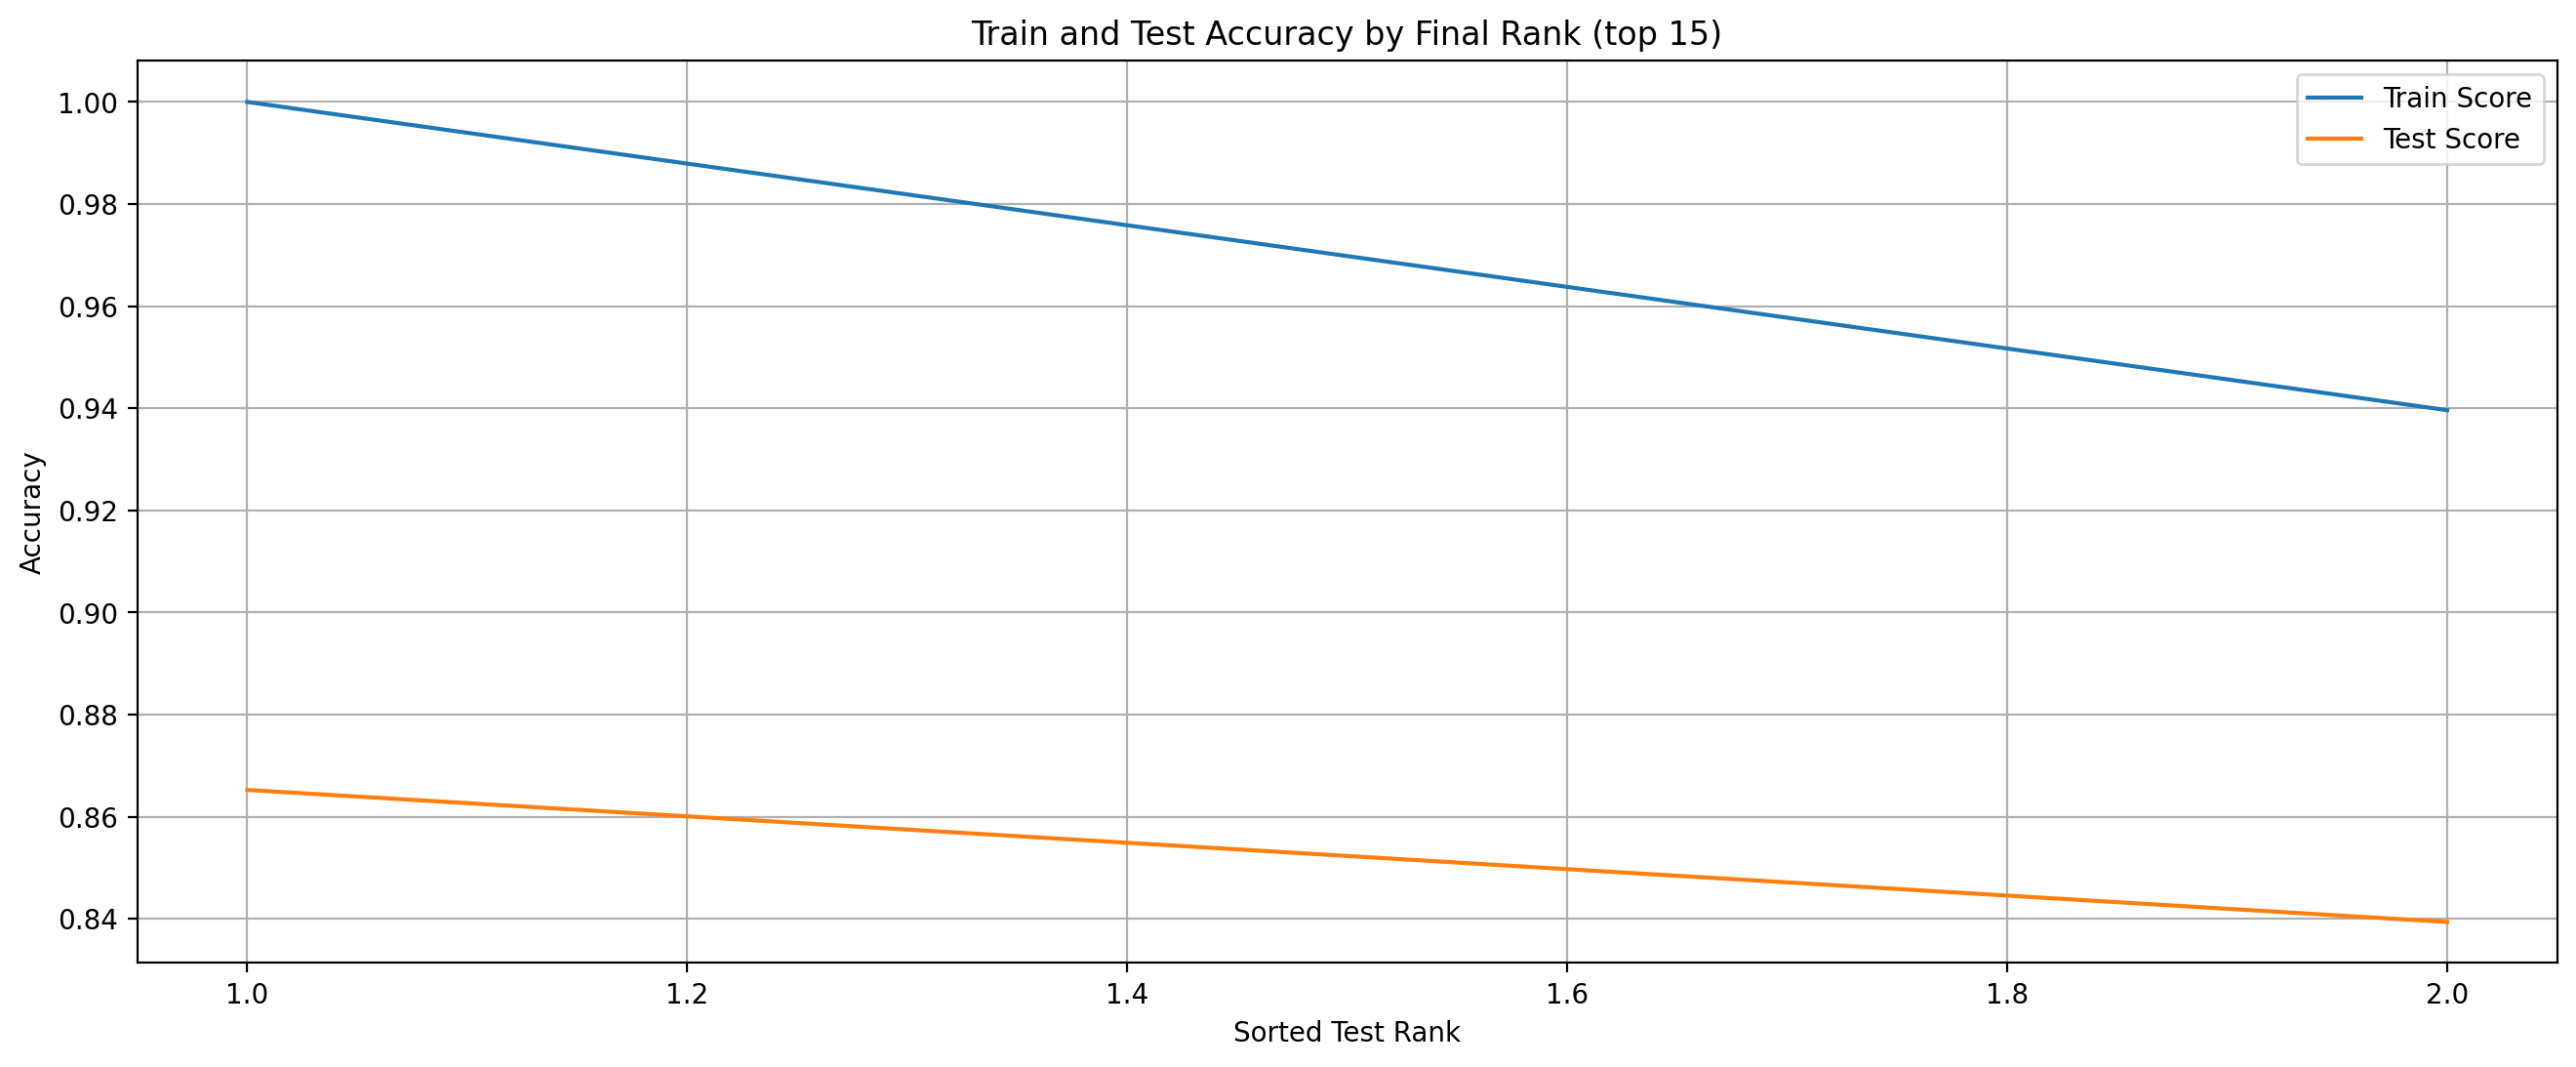

In [11]:
plt.figure(figsize=(16, 6))    

plt.plot(sorted_cv['rank_test_score'], sorted_cv['mean_train_score'], label="Train Score")
plt.plot(sorted_cv['rank_test_score'], sorted_cv['mean_test_score'], label="Test Score")

plt.grid()
plt.xlabel('Sorted Test Rank')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy by Final Rank (top 15)')
plt.legend(loc='best')

filename = "test_train_by_rank.png"
plt.savefig(os.path.join(results_path, filename))

plt.show()

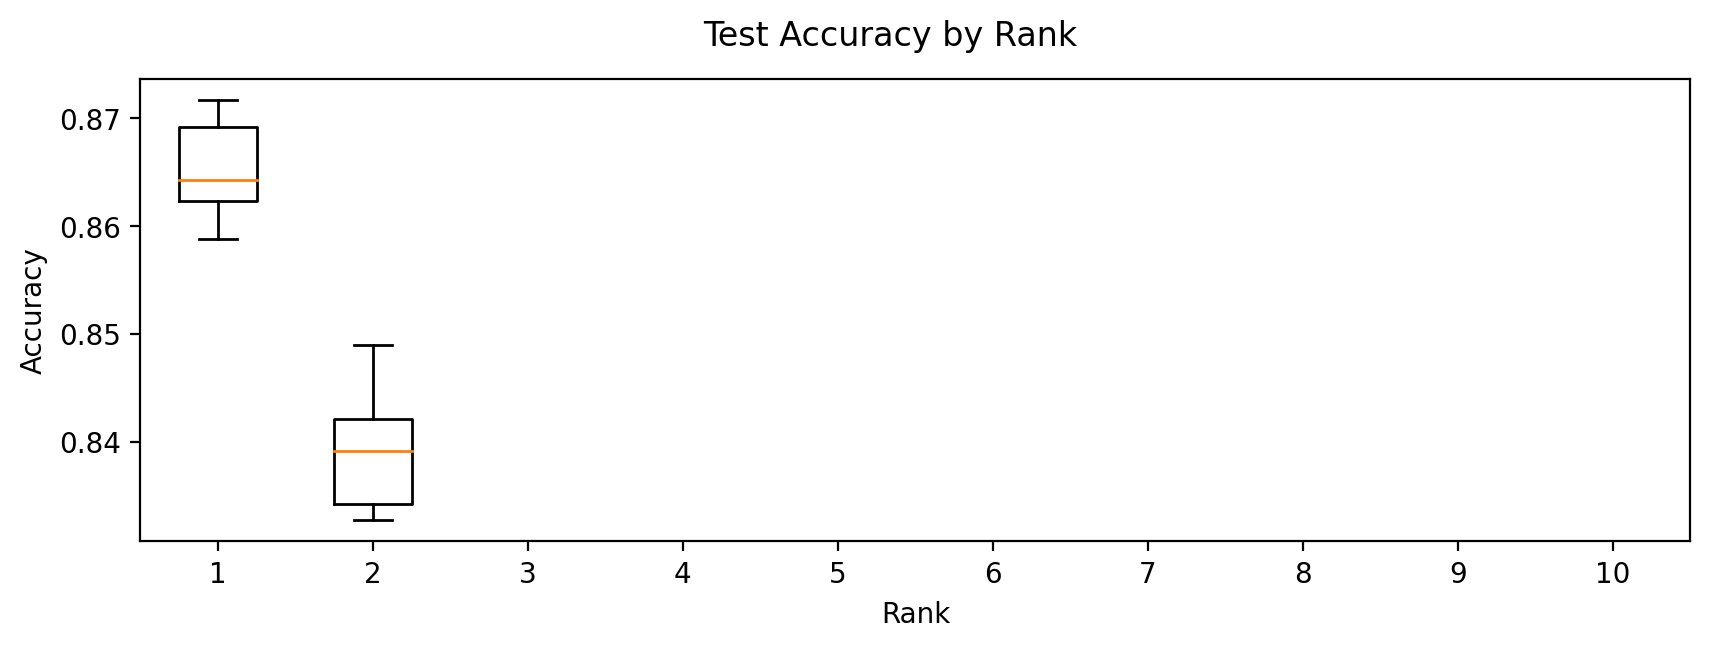

In [12]:
# boxplot algorithm comparison
fig = plt.figure(figsize=(10, 3))
fig.suptitle('Test Accuracy by Rank')

ax = fig.add_subplot(111)

plt.boxplot(sorted_cv.iloc[:10, :][['split0_test_score', 'split1_test_score', 'split2_test_score',
   'split3_test_score', 'split4_test_score']].T)
ax.set_xticklabels(range(1, 11))
ax.set_xlabel("Rank")
ax.set_ylabel("Accuracy")

filename = "test_accuracy_by_rank.png"
plt.savefig(os.path.join(results_path, filename))

plt.show()

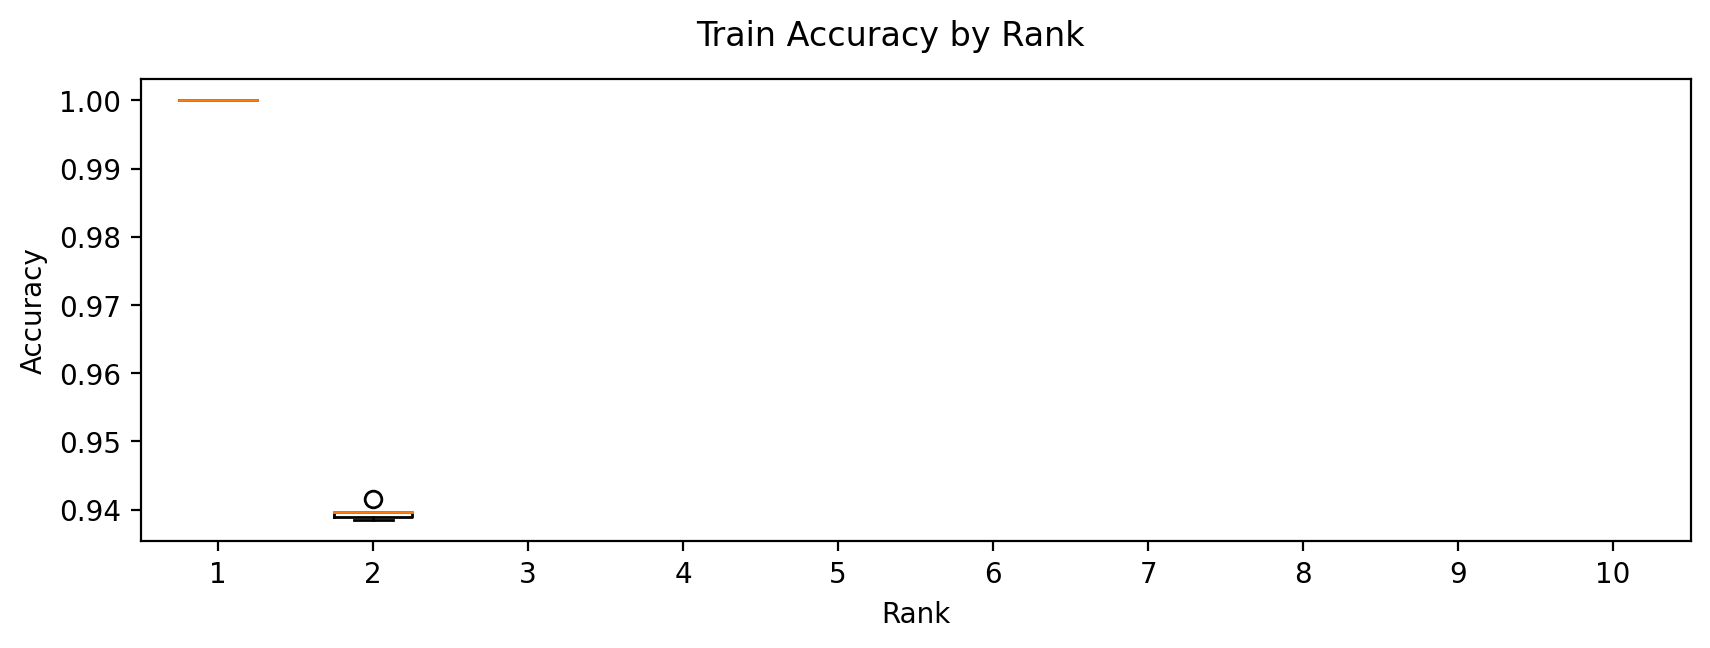

In [13]:
# boxplot algorithm comparison
fig = plt.figure(figsize=(10, 3))
fig.suptitle('Train Accuracy by Rank')

ax = fig.add_subplot(111)

plt.boxplot(sorted_cv.iloc[:10, :][['split0_train_score', 'split1_train_score', 'split2_train_score',
   'split3_train_score', 'split4_train_score']].T)
ax.set_xticklabels(range(1, 11))
ax.set_xlabel("Rank")
ax.set_ylabel("Accuracy")

filename = "train_accuracy_by_rank.png"
plt.savefig(os.path.join(results_path, filename))

plt.show()

In [14]:
max_params = cv_results.loc[cv_results['rank_test_score'] == 1]
best_params = max_params.params.values[0]

In [15]:
print(f"Mean Train set, Accuracy = {max_params['mean_train_score'].values[0]:.2f}")
print(f"Mean Test  set, Accuracy = {max_params['mean_test_score'].values[0]:.2f}")

Mean Train set, Accuracy = 1.00
Mean Test  set, Accuracy = 0.87


In [16]:
random_search = pickle.load(open(os.path.join(results_path, file_name), "rb"))
model = random_search.best_estimator_

#model = LGBMClassifier(**best_params)
#model.fit(X_train, y_train)

y_train_prediction = model.predict(X_train)
y_test_prediction = model.predict(X_test)

FileNotFoundError: [Errno 2] No such file or directory: './tuning_results/tuning_lgbm/202402271426/Assets/lgbm_202402271426.pkl'

In [ ]:
print(f"Train set, Accuracy = {accuracy_score(y_train, y_train_prediction):.2f}")
print(f"Test set, Accuracy = {accuracy_score(y_test, y_test_prediction):.2f}")

In [ ]:
ind = np.argpartition(model.feature_importances_, -20)[-20:]

features = X.columns[ind]
importance = model.feature_importances_[ind]

fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(ind)), importance, align='center')
plt.yticks(range(len(ind)), features)
plt.title('Feature Importance LGBM')
plt.grid()

filename = "feature_importance.png"
plt.savefig(os.path.join(results_path, filename))
            
plt.show()

In [ ]:
# TEST
for col in ['param_n_estimators', 'param_learning_rate']:
    
    plt.figure(figsize=(16, 6))    

    m, b = np.polyfit(list(sorted_cv['rank_test_score'].values), list(sorted_cv[col].values), 1)
    plt.plot(sorted_cv['rank_test_score'], m * sorted_cv['rank_test_score'] + b, c='r', label="Regression Line")
    plt.plot(sorted_cv['rank_test_score'], sorted_cv[col], label=f"{col} Values")
    
    plt.grid()
    plt.xlabel('Hyperparameter Values')
    plt.ylabel('Parameter Value')
    plt.title(col)
    plt.legend(loc='best')

    
    filename = f"{col}_by_rank.png"
    plt.savefig(os.path.join(results_path, filename))
                  
    plt.show()


# Hyperparameter Evaluation

In [ ]:

def plot_parameters(x_values, title):
    
    fig, ax1 = plt.subplots(figsize=(16, 6))
    ax2 = ax1.twinx()

    ax1.scatter(x_values, cv_results['mean_test_score'], label='mean_test_score', c='b')
    ax2.scatter(x_values, cv_results['std_test_score'], label='std_test_score', c='r')

    m, b = np.polyfit(list(x_values.values), list(cv_results['mean_test_score'].values), 1)
    ax1.plot(x_values, m * x_values + b, c='b')

    m, b = np.polyfit(list(x_values.values), list(cv_results['std_test_score'].values), 1)
    ax2.plot(x_values, m * x_values + b, c='r')
    
    ax1.set_title(title)
    ax1.set_xlabel('Parameter Value')
    ax1.set_ylabel('Mean Test Score')
    ax2.set_ylabel('Standard Deviation of Test Score')
    ax1.grid(True)
    
    
    # Combine the legends from both axes
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper right')

    filename = f"{title}_test_score.png"
    plt.savefig(os.path.join(results_path, filename))
            
    plt.show()



In [ ]:

for param in ['param_n_estimators', 'param_learning_rate']:
    x_values = cv_results[param]
    plot_parameters(x_values, param)

# Plotting Evaluation Metrics (Precision, Recall, F1-Score, AUC-ROC):


In [ ]:

# For multiclass classification, you need to binarize the labels
y_true_bin = label_binarize(y_test, classes=np.unique(y_test))
y_score_bin = label_binarize(y_test_prediction, classes=np.unique(y_test_prediction))

auc_roc = roc_auc_score(y_true_bin, y_score_bin, average='macro')

# Plot Precision-Recall curve for each class
precision = dict()
recall = dict()

plt.figure(figsize=(16, 6))    
for i in range(7):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_score_bin[:, i])
    plt.plot(recall[i], precision[i], label='Covertype {}'.format(i + 1))

plt.grid()
plt.xlabel('Recall')
plt.ylabel('True Positive Rate / Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')

filename = "precision_recall.png"
plt.savefig(os.path.join(results_path, filename))
            
plt.show()


# Plot AUC-ROC curve for each class
fpr = dict()
tpr = dict()

plt.figure(figsize=(16, 6))    
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score_bin[:, i])
    plt.plot(fpr[i], tpr[i], label='Covertype {}'.format(i + 1))

plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate / Precision')
plt.title('ROC Curve')
plt.legend(loc='best')
            
filename = "roc_curve.png"
plt.savefig(os.path.join(results_path, filename))
            
plt.show()


# Partial Dependence

In [ ]:
# potentially iterate over features (and relation ie 0 to 1)

In [ ]:

features, feature_names = [(0,)], [f"Features #{i}" for i in range(X.shape[1])]
deciles = {0: np.linspace(0, 1, num=5)}

pd_results = partial_dependence(
    model, X, features=1, kind="average", grid_resolution=5)

display = PartialDependenceDisplay(
    [pd_results], features=features, feature_names=feature_names,
    target_idx=0, deciles=deciles
)
display.plot(pdp_lim={1: (-1.38, 0.66)})

plt.grid()
plt.xlabel('Feature Value')
plt.ylabel('Partial Dependence') 
plt.title('Partial Dependence')

filename = "partial_dependence.png"
plt.savefig(os.path.join(results_path, filename))
            
plt.show()


# Confusion Matrix

In [ ]:

class_names = np.unique(y)

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        model,
        X_test,
        y_test,
        display_labels=class_names + 1,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    png_name = title.lower().replace(" ", "_")
    filename = f"{png_name}.png"
    plt.savefig(os.path.join(results_path, filename))

plt.show()

# Shap Values

In [ ]:
explainer = shap.TreeExplainer(model)
explanation = explainer.shap_values(X_test, check_additivity=False)


In [ ]:
shap.summary_plot(explanation, X_test, plot_type="bar", show=False)

filename = f"shap_summary.png"
plt.savefig(os.path.join(results_path, filename))
plt.close()  

[CV 3/5; 2/10] START colsample_bytree=0.6589759616304657, learning_rate=0.16711270014304275, min_child_samples=58, min_child_weight=0.009431248547993355, n_estimators=318, num_leaves=32, reg_alpha=0.9984790421511461, reg_lambda=0.7116978913334834, subsample=1.2371418090560016
[CV 3/5; 2/10] END colsample_bytree=0.6589759616304657, learning_rate=0.16711270014304275, min_child_samples=58, min_child_weight=0.009431248547993355, n_estimators=318, num_leaves=32, reg_alpha=0.9984790421511461, reg_lambda=0.7116978913334834, subsample=1.2371418090560016;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5; 2/10] START colsample_bytree=0.6589759616304657, learning_rate=0.16711270014304275, min_child_samples=58, min_child_weight=0.009431248547993355, n_estimators=318, num_leaves=32, reg_alpha=0.9984790421511461, reg_lambda=0.7116978913334834, subsample=1.2371418090560016
[CV 4/5; 2/10] END colsample_bytree=0.6589759616304657, learning_rate=0.16711270014304275, min_child_samples=58, min_child

[CV 2/5; 2/10] START colsample_bytree=0.6589759616304657, learning_rate=0.16711270014304275, min_child_samples=58, min_child_weight=0.009431248547993355, n_estimators=318, num_leaves=32, reg_alpha=0.9984790421511461, reg_lambda=0.7116978913334834, subsample=1.2371418090560016
[CV 2/5; 2/10] END colsample_bytree=0.6589759616304657, learning_rate=0.16711270014304275, min_child_samples=58, min_child_weight=0.009431248547993355, n_estimators=318, num_leaves=32, reg_alpha=0.9984790421511461, reg_lambda=0.7116978913334834, subsample=1.2371418090560016;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5; 3/10] START colsample_bytree=0.9376144220391761, learning_rate=0.18383978607229587, min_child_samples=394, min_child_weight=0.00041273720740810484, n_estimators=215, num_leaves=33, reg_alpha=0.9520706479358323, reg_lambda=0.5718463048098278, subsample=1.45804052850331
[CV 1/5; 3/10] END colsample_bytree=0.9376144220391761, learning_rate=0.18383978607229587, min_child_samples=394, min_chi

SHAP values show how each feature affects each final prediction, the significance of each feature compared to others, and the model's reliance on the interaction between features.
